# **Detect Moving Objects**

In this notebook, we will detect moving objects from a drone video

### Algorithm Outline

For a pair of sequential frames, frame 1 and frame 2
1. Compute key points on frame 1
2. Compute Sparse Optical Flow from frame 1 to frame 2
3. Perform Motion Compensation to Obtain Compensated key points
4. Compute Norm of the Compensated Flow Vectors
5. Perform outlier detection on Norm to get motion points
6. Cluster motion points to get detection
7. Filter detected clusters

In [1]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from motion_detection_utils import *

Get video sequence from Virat Video Dataset

In [2]:
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000352_05980_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

196

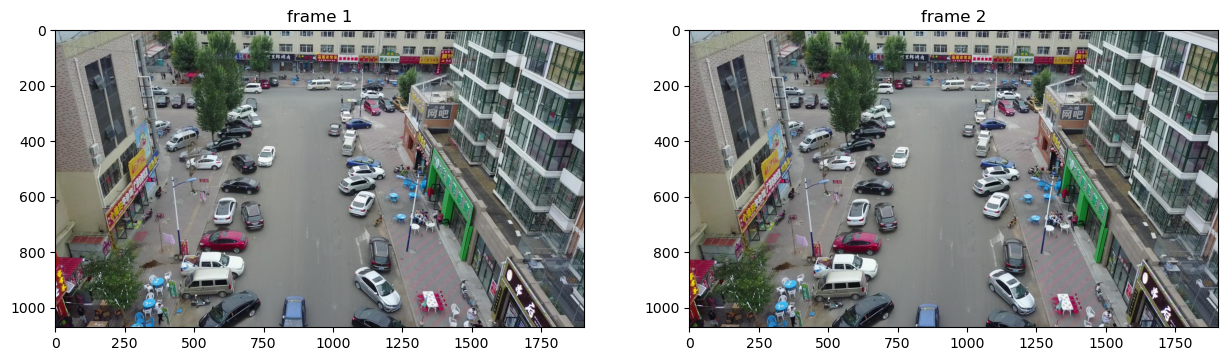

In [3]:
idx = 9
frame1 = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cv2.imread(image_paths[idx + 1]), cv2.COLOR_BGR2RGB)

_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(frame1)
ax[0].set_title("frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

# **Camera Motion Compensation**

Now we will implement camera motion compensation to get a better flow estimate with a moving ego camera

In [4]:
def motion_comp(prev_frame, curr_frame, num_points=500, points_to_use=500, transform_type='affine'):
    """ Obtains new warped frame1 to account for camera (ego) motion
        Inputs:
            prev_frame - first image frame
            curr_frame - second sequential image frame
            num_points - number of feature points to obtain from the images
            points_to_use - number of point to use for motion translation estimation 
            transform_type - type of transform to use: either 'affine' or 'homography'
        Outputs:
            A - estimated motion translation matrix or homography matrix
            prev_points - feature points obtained on previous image
            curr_points - feature points obtaine on current image
        """
    transform_type = transform_type.lower()
    assert(transform_type in ['affine', 'homography'])

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)

    # get features for first frame
    corners = cv2.goodFeaturesToTrack(prev_gray, num_points, qualityLevel=0.01, minDistance=10)

    # get matching features in next frame with Sparse Optical Flow Estimation
    matched_corners, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, corners, None)

    # reformat previous and current corner points
    prev_points = corners[status==1]
    curr_points = matched_corners[status==1]

    # sub sample number of points so we don't overfit
    if points_to_use > prev_points.shape[0]:
        points_to_use = prev_points.shape[0]

    index = np.random.choice(prev_points.shape[0], size=points_to_use, replace=False)
    prev_points_used = prev_points[index]
    curr_points_used = curr_points[index]

    # find transformation matrix from frame 1 to frame 2
    if transform_type == 'affine':
        A, _ = cv2.estimateAffine2D(prev_points_used, curr_points_used, method=cv2.RANSAC)
    elif transform_type == 'homography':
        A, _ = cv2.findHomography(prev_points_used, curr_points_used)

    return A, prev_points, curr_points

Get warped/transformed frame 1

In [5]:
A, prev_points, curr_points = motion_comp(frame1, frame2, num_points=10000, points_to_use=10000, transform_type='affine')

In [6]:
# warp frame 1 to account for camera motion
transformed1 = cv2.warpAffine(frame1, A, dsize=(frame1.shape[:2][::-1])) # affine transform
# transformed1 = cv2.warpPerspective(frame1, A, dsize=(frame1.shape[:2][::-1])) # homography transform

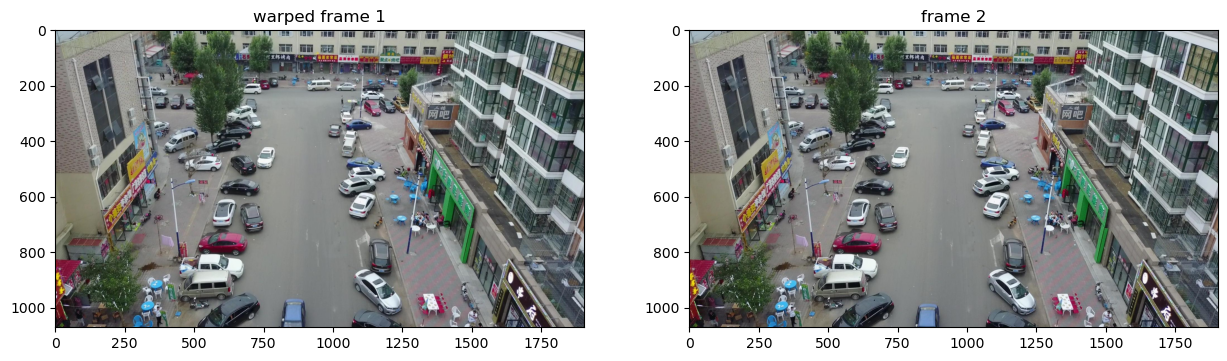

In [7]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(transformed1)
ax[0].set_title("warped frame 1")
ax[1].imshow(frame2)
ax[1].set_title("frame 2");

##### Compare deltas between corrected and un corrected images

In [8]:
og_delta = cv2.subtract(frame2, frame1)
comped_delta = cv2.subtract(frame2, transformed1)

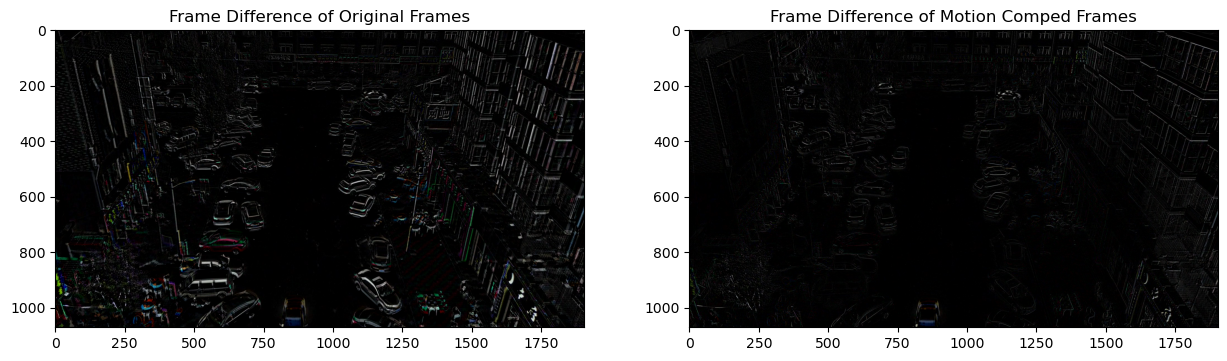

In [9]:
_, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(og_delta)
ax[0].set_title("Frame Difference of Original Frames")
ax[1].imshow(comped_delta)
ax[1].set_title("Frame Difference of Motion Comped Frames");

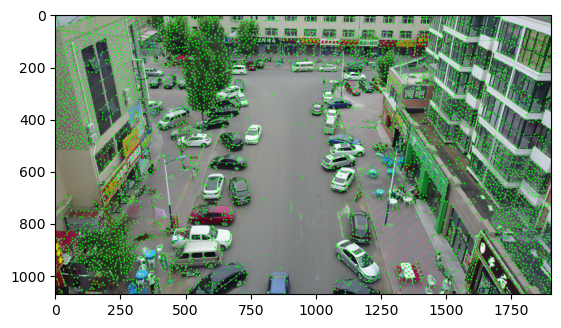

In [10]:
img = plot_points(frame2.copy(), curr_points)

plt.imshow(img)

#### Use the Affine Transformation matrix to transform the previous points and account for the ego motion

In [11]:
# affine
A = np.vstack((A, np.zeros((3,)))) # get 3x3 matrix to xform points
compensated_points = np.hstack((prev_points, np.ones((len(prev_points), 1)))) @ A.T 

# homography
# warped_points = np.hstack((prev_points, np.ones((len(prev_points), 1)))) @ A.T


compensated_points = compensated_points[:, :2]

#### Compare Original VS Warped Flow Vectors

In [13]:
print(f" Prev Key Points: {np.round(prev_points[100], 2)} \n",
      f"Compensated Key Points: {np.round(compensated_points[100], 2)} \n",
      f"Current Key Points: {np.round(curr_points[100], 2)}")

 Prev Key Points: [528. 837.] 
 Compensated Key Points: [524.31 845.49] 
 Current Key Points: [524.33 845.14]


In [14]:
flow = curr_points - prev_points
compensated_flow = curr_points - compensated_points

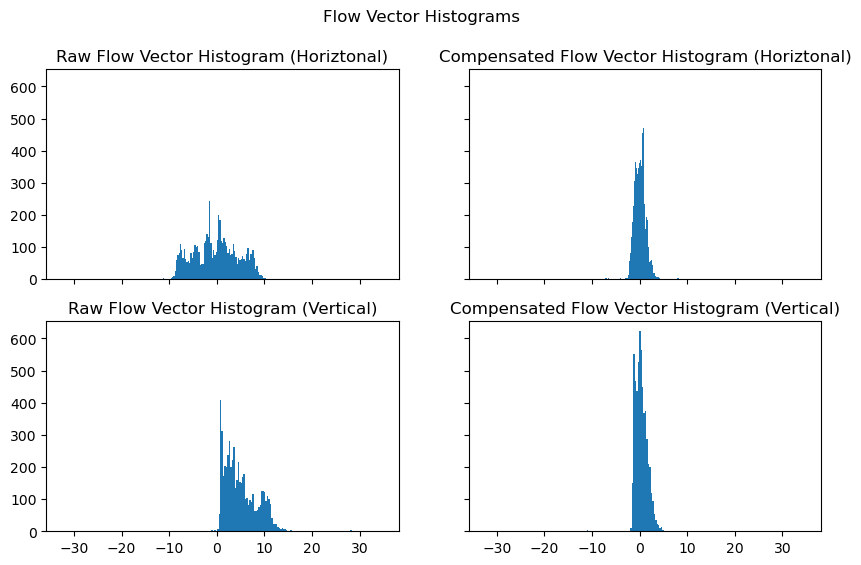

In [15]:
num_bins = 200
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle("Flow Vector Histograms")
ax[0][0].hist(flow[:, 0], bins=num_bins) # curr_points[:, 0] - prev_points[:, 0], bins=num_bins);
ax[0][0].set_title("Raw Flow Vector Histogram (Horiztonal)")
ax[0][1].hist(compensated_flow[:, 0], bins=num_bins);
ax[0][1].set_title("Compensated Flow Vector Histogram (Horiztonal)");

ax[1][0].hist(flow[:, 1], bins=num_bins);
ax[1][0].set_title("Raw Flow Vector Histogram (Vertical)")
ax[1][1].hist(compensated_flow[:, 1], bins=num_bins);
ax[1][1].set_title("Compensated Flow Vector Histogram (Vertical)");

### Obtain Outlier Detection Bound

In [16]:
import scipy
from scipy.stats import kurtosis

c = 2 # tunable scale factor
comp = 500

# Obtain distance metric for displacement
# x = np.sum(np.abs(compensated_flow), axis=1) # l1 norm
x = np.linalg.norm(compensated_flow, ord=2, axis=1) # l2 norm

# get various statistics
mu = np.mean(x)
sig = np.std(x, ddof=1) # unbiased estimator?
med = np.median(x)
mad = np.median(np.abs(x - med)) # Median Absolute Deviation
iqr = scipy.stats.iqr(x)
q1 = np.percentile(x, 25)
q3 = np.percentile(x, 75)

# get Kurtosis
# We expect a very Leptokurtic distribution with extrememly long tails noting the outliers
k = kurtosis(x, bias=False, fisher=True)

# if distriubtion doesn't have too long of tails reduce outlier threshold parameter 
if k < 1:
    c /= 2
    

# upper and lower bounds for outlier detection
upper_bound = mu + c*sig
lower_bound = mu - c*sig

# display statistics
print(f"Sample Mean: {mu :.4f}, Sample Std Dev: {sig :.4f} IQR: {iqr :.4f}\n"
      f"Sample Median: {med :.4f} MAD: {mad :.4f} \n"
      f"Upper Outlier Bound: {upper_bound :.4f} Lower Outlier Bound: {lower_bound :.4f} \n"
      f"Kurtosis: {k :.4f}")

Sample Mean: 1.5733, Sample Std Dev: 1.6844 IQR: 1.0587
Sample Median: 1.2378 MAD: 0.4832 
Upper Outlier Bound: 4.9421 Lower Outlier Bound: -1.7954 
Kurtosis: 116.3240


## Plot Histograms of Both Norms

In [17]:
l1 = np.sum(np.abs(compensated_flow), axis=1) # l1 norm
l2 = np.linalg.norm(compensated_flow, ord=2, axis=1) # l2 norm

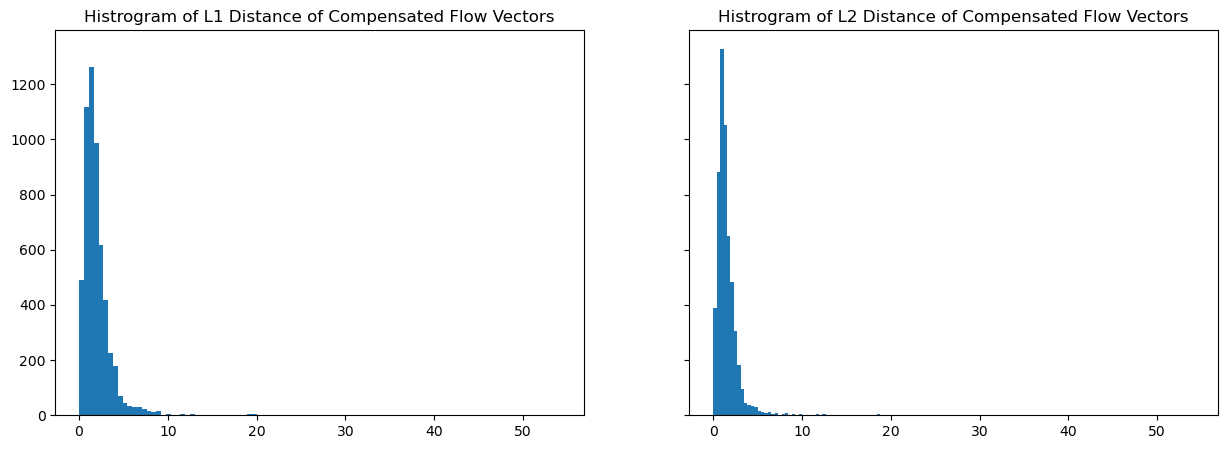

In [18]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax[0].hist(l1, bins=100);
ax[0].set_title("Histrogram of L1 Distance of Compensated Flow Vectors")
ax[1].hist(l2, bins=100);
ax[1].set_title("Histrogram of L2 Distance of Compensated Flow Vectors");

Let's plot the histogram of the distance between the current key points and the warped/transformed previous key points. This will give us a notion of the outliers in the data, detecting these outliers will give us the moving objects.

Let's also fit a Laplacian Distribution to the data where:

$$

\sigma^2 = 2b^2 \rightarrow \sigma = \sqrt{2}b \rightarrow b = \sigma/\sqrt{2}

$$

In [19]:
lap_dist = lambda x, b, mu : (1/(2*b)) * np.exp(-np.abs(x - mu)/b)
# log_normal = lambda x, mu, sig : (1/(x*sig*np.sqrt(2*np.pi)) * np.exp(-np.log(x - mu)**2 / (2*sig**2)) )
# b = sig/np.sqrt(2)
b = np.sqrt(sig/2) # gives a better fit
vals = np.arange(x.min(), x.max(), 0.1)

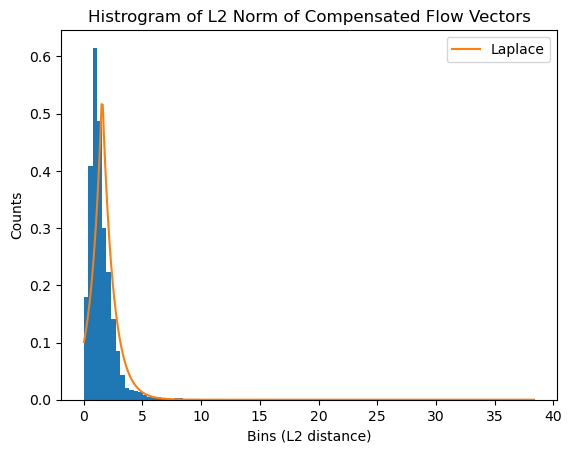

In [20]:
plt.hist(x, bins=100, density=True);
plt.plot(vals, lap_dist(vals, b, mu), label="Laplace");
plt.title("Histrogram of L2 Norm of Compensated Flow Vectors");
plt.ylabel("Counts");
plt.xlabel("Bins (L2 distance)");
plt.legend();

Get index for motion points

In [22]:
motion_idx = (x >= upper_bound)
motion_idx.sum()

121

Possibly use the Kurtosis to help determine the optimal threshold, may need to train a lienar model for this

Need to find a way to get the optimal threshold. Possible shoose several thresholds and stop when an optimal number of points is reached. i.e. if we get 2000 motion points, then we need to increase the threshold. Need to find a more statistically sound method that will adapt to different changin conditions.

### Display Motion Points

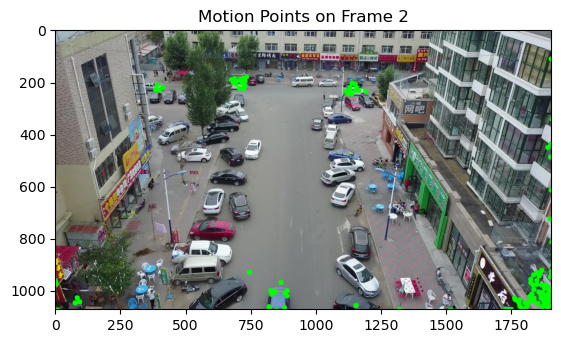

In [23]:
motion_points = curr_points[motion_idx]
motion_flow = compensated_flow[motion_idx]
img = plot_points(frame2.copy(), motion_points, radius=10)

plt.imshow(img)
plt.title("Motion Points on Frame 2");

##### Use other features to perform clustering

- Magnitude
- Angle

In [25]:
motion = compensated_points[motion_idx] - curr_points[motion_idx] # curr_points[idx] - compensated_points[idx]
magnitude = np.linalg.norm(motion, ord=2, axis=1)
angle = np.arctan2(motion[:, 0], motion[:, 1]) # horizontal/vertial

X = np.hstack((motion_points, np.c_[magnitude], np.c_[angle]))
X.shape

(121, 4)

### Cluster the detected motion points

In [26]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=30.0, min_samples=3)
clustering.fit(X)

DBSCAN(eps=30.0, min_samples=3)

In [27]:
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

Draw all clusters

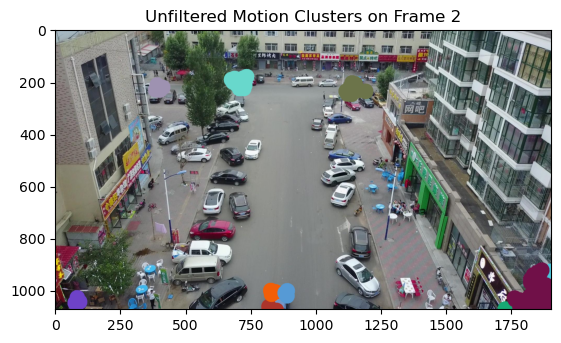

In [28]:
img = frame2.copy()
for i, lbl in enumerate(clustering.labels_):
    if lbl >= 0:
        color = get_color((i+1)*1)
        img = plot_points(img, motion_points[clustering.labels_ == lbl], radius=30, color=color)

plt.imshow(img)
plt.title("Unfiltered Motion Clusters on Frame 2");

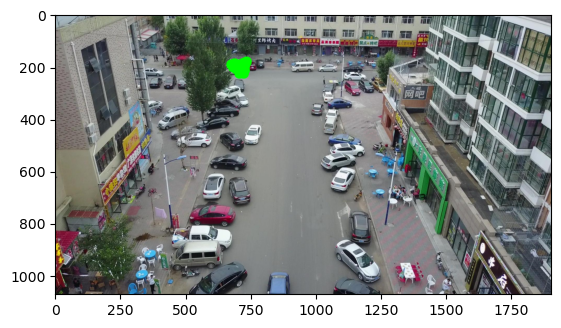

In [29]:
lbl = 0
img = plot_points(frame2.copy(), motion_points[clustering.labels_ == lbl], radius=20)

plt.imshow(img)

### Filter Clusters 

- Remove clusters with non-uniform direction
- Remove cluster close to the edges

Clusters of real objects should have uniform direction, so we will filter the clusters based on standard deviation of detected flow vectors.

In [31]:
h, w, _ = frame1.shape
w,h

(1904, 1071)

In [32]:
# set angle uniformity threshold
angle_thresh = 0.15 # angular threshold in radians
edge_thresh = 50 # threshol of which to remove clusters that appear on the edges
cluster_labels = [] # clusters to keep
clusters = []
for lbl in np.unique(clustering.labels_):

    angle_std = angle[clustering.labels_ == lbl].std(ddof=1)
    if angle_std <= angle_thresh:
        cluster = motion_points[clustering.labels_ == lbl]

        # remove clusters that are too close to the edges
        centroid = cluster.mean(axis=0)
        if not (np.any(centroid < edge_thresh) or np.any(centroid > np.array([w - edge_thresh, h - edge_thresh]))):
            cluster_labels.append(lbl)
            clusters.append(cluster)

    # TEMP
    # print(np.degrees(np.arctan2(delta[:,0], delta[:,1])).std())
    # print(np.arctan2(delta[:,0], delta[:,1]).std())
    # print()

cluster_labels

[0, 1, 5, 6, 7]

## Draw Detected Clusters

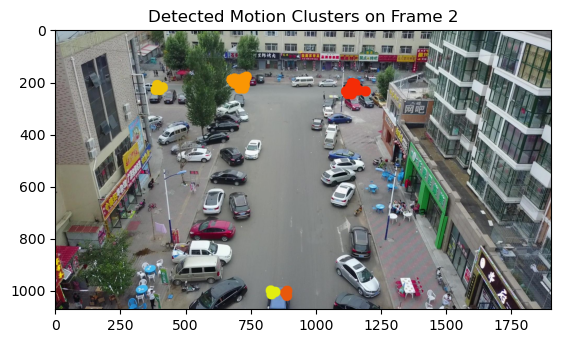

In [33]:
img = frame2.copy()
for i, cluster in enumerate(clusters):
    color = get_color((i+1)*5)
    img = plot_points(img, cluster, radius=20, color=color)

plt.imshow(img)
plt.title("Detected Motion Clusters on Frame 2");

## Make Pipeline

For a pair of sequential frames, frame 1 and frame 2
1. Obtain Keypoints for frame 1
2. Use sparse Optical Flow to propagate Keypoints to frame 2 and compute flow vectors
3. Get Transformation matrix from frame 1 to frame 2
4. Transform/warp frame 1 key points
5. Get Norm of flow vectors
6. Get outlier bounds for distance metric
7. Use outlier bounds to detect Motion Points
8. Cluster Motion Points
9. Filter clusters with large variation in angular motion

In [34]:
from scipy.stats import kurtosis


def get_motion_detections(frame1, 
                          frame2, 
                          cluster_model, 
                          c=2, 
                          angle_thresh=0.1, 
                          edge_thresh=50, 
                          max_cluster_size=80, 
                          distance_metric='l2', 
                          transform_type='affine'):
    """ Obtains detected motion betweej frame 1 and frame 2 
        Inputs:
            frame1 - previous frame
            frame2 - current frame
            cluster_model - cluster model object
            c - tunable threshold hyperparamer for outlier detection
            angle_thresh - threshold for angular uniformity of the cluster 
                (Determines if the Std Dev of the Cluster flow angles is too large)
            edge_thresh - min pixel distance to edge for cluster removal
                clusters close to the edge usually correspond to false detections
            max_cluster_size - max number of points for a cluster
            distance_metric - used to compute the distance between current and previous keypoints
            transform_type - type of transform to use: either 'affine' or 'homography'
        Outputs:
            clusters - list containing clusters of detected motion keypoints
        """
    transform_type = transform_type.lower()
    assert(transform_type in ['affine', 'homography'])

    # get frame info
    h, w, _ = frame1.shape

    # get affine transformation matrix for motion compensation between frames
    A, prev_points, curr_points = motion_comp(frame1, frame2, num_points=10000, points_to_use=5000, transform_type=transform_type)

    # get transformed key points
    if transform_type == 'affine':
        A = np.vstack((A, np.zeros((3,)))) # get 3x3 matrix to xform points

    compensated_points = np.hstack((prev_points, np.ones((len(prev_points), 1)))) @ A.T
    compensated_points = compensated_points[:, :2]

    # get a distance metric for the current and previous keypoints
    if distance_metric == 'l1':
        x = np.sum(np.abs(curr_points - compensated_points), axis=1) # l1 norm
    else:
        x = np.linalg.norm(curr_points - compensated_points, ord=2, axis=1) # l2 norm
    
    # # compute kurtosis of x to determine outlier hyperparameter c
    # NOTE: We expect a Letpokurtic distribution with a heavy positive tail
    # If we don't have extremely heavy tails reduce outlier threshold parameter
    if kurtosis(x, bias=False) < 1:
        c /= 2 # reduce outlier hyparameter

    # get outlier bound (only care about upper bound since lower values are not likely movers)
    upper_bound = np.mean(x) + c*np.std(x, ddof=1)

    # get motion points
    motion_idx = (x >= upper_bound)
    motion_points = curr_points[motion_idx]

    # add additional motion data for clustering
    motion = compensated_points[motion_idx] - motion_points
    magnitude = np.linalg.norm(motion, ord=2, axis=1)
    angle = np.arctan2(motion[:, 0], motion[:, 1]) # horizontal/vertial

    motion_data = np.hstack((motion_points, np.c_[magnitude], np.c_[angle]))

    # cluster motion data
    cluster_model.fit(motion_data)

    
    # filter clusters with large variation in angular motion
    clusters = []
    far_edge_array = np.array([w - edge_thresh, h - edge_thresh])
    for lbl in np.unique(cluster_model.labels_):
        
        cluster_idx = cluster_model.labels_ == lbl
        
        # get standard deviation of the angle of apparent motion 
        angle_std = angle[cluster_idx].std(ddof=1)
        if angle_std <= angle_thresh:
            cluster = motion_points[cluster_idx]

            # remove clusters that are too close to the edges and ones that are too large
            centroid = cluster.mean(axis=0)
            if (len(cluster) < max_cluster_size) \
                and not (np.any(centroid < edge_thresh) or np.any(centroid > far_edge_array)):
                clusters.append(cluster)

    return clusters


In [41]:
cluster_model = DBSCAN(eps=50.0, min_samples=5)

In [52]:
%timeit clusters = get_motion_detections(frame1, frame2, cluster_model, angle_thresh=0.1, distance_metric='l2', transform_type='affine')

51 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Iterate through all frames

In [56]:
cluster_model = DBSCAN(eps=30.0, min_samples=3) 

# get previous frame
prev_frame = cv2.imread(image_paths[0])
curr_frame = None

frames = []
for i in range(1, len(image_paths)):
    curr_frame = cv2.imread(image_paths[i])

    # get detected cluster
    clusters = get_motion_detections(prev_frame, 
                                     curr_frame, 
                                     cluster_model, 
                                     c=1,
                                     angle_thresh=0.1, 
                                     max_cluster_size=50,
                                     distance_metric='l2', 
                                     transform_type='affine')

    # save previous frame for next iteration
    prev_frame = curr_frame.copy()

    # draw detected clusters
    for j, cluster in enumerate(clusters):
        color = get_color((j+1)*5)
        curr_frame = plot_points(curr_frame, cluster, radius=10, color=color)

    # save image for GIF
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(cv2.resize(curr_frame, (952, 535)))
    plt.axis('off')
    fig.savefig(f"temp/frame_{i}.png")
    plt.close();
    
    frames.append(curr_frame)

    

c:\Users\itber\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\itber\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


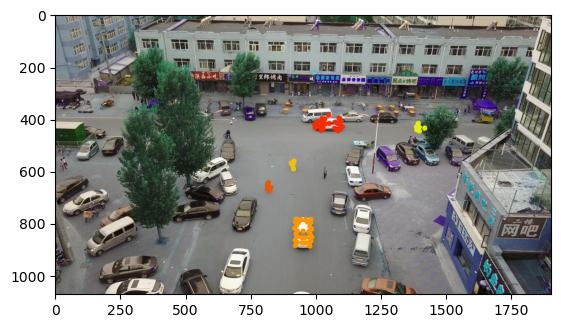

In [57]:
plt.imshow(frames[185])

#### Make Video

In [58]:
out = cv2.VideoWriter('drone_detection_sparse_affine.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 15, (1904, 1071))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()

### Make GIF

In [50]:
create_gif_from_images('drone_detection_sparse_affine.gif', 'temp', '.png', duration=75)

## How about another video?

In [59]:
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000013_00000_v"
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000013_01073_v"
# fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000360_00001_v"
fpath = r"C:\Users\itber\Documents\datasets\VisDrone\VisDrone2019-VID-train\sequences\uav0000361_02323_v"

image_paths = sorted(glob(f"{fpath}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
len(image_paths)

219

In [63]:
cluster_model = DBSCAN(eps=30.0, min_samples=3) # DBSCAN is seems to work the best

frames = []
for i in range(len(image_paths) - 1):
    frame1 = cv2.imread(image_paths[i])
    frame2 = cv2.imread(image_paths[i + 1])

    # get detected cluster
    clusters = get_motion_detections(frame1, 
                                     frame2, 
                                     cluster_model, 
                                     c=0.5, # 1,
                                     angle_thresh=0.1, 
                                     max_cluster_size=50,
                                     distance_metric='l2', 
                                     transform_type='affine')

    # draw detected clusters
    for j, cluster in enumerate(clusters):
        color = get_color((j+1)*5)
        frame2 = plot_points(frame2, cluster, radius=10, color=color)

    # save image for GIF
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(cv2.resize(frame2, (952, 535)))
    plt.axis('off')
    fig.savefig(f"temp/frame_{i}.png")
    plt.close();
    
    frames.append(frame2)

In [ ]:
out = cv2.VideoWriter('drone_detection_sparse_361.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 15, (frames[0].shape[:2][::-1]))

for img in frames:
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()
del out

In [ ]:
create_gif_from_images('drone_detection_sparse_361.gif', 'temp', '.png', duration=75)